<a href="https://colab.research.google.com/github/GIThadasAI/yoganet/blob/main/object_detection_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [26]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached https://files.pythonhosted.org/packages/3d/be/679ce5254a8c8d07470efb4a4c00345fae91f766e64f1c2aece8796d7218/tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/f5/926ae53d6a226ec0fda5208e0e581cffed895ccc89e36ba76a8e60895b78/tensorflow_estimator-2.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/74/0a6fcb206dcc72a6da9a62dd81784bfdbff5fedb099982861dc2219014fb/tensorboard-2.2.2-py3-none-any.whl
ERROR: tf-models-official 2.3.0 has requirement tensorflow>=2.3.0, but you'll have tensorflow 2.2.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.

In [27]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Using cached https://files.pythonhosted.org/packages/7a/ce/e76c4e3d2c245f4f20eff1bf9cbcc602109448142881e1f946ba2d7327bb/tensorflow-2.4.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/74/7e/622d9849abf3afb81e482ffc170758742e392ee129ce1540611199a59237/tensorflow_estimator-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/02/83/179c8f76e5716030cc3ee9433721161cfcc1d854e9ba20c9205180bb100a/tensorboard-2.4.0-py3-none-any.whl
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1606870 sha256=296e0967f487d4a875457bd6c5427f10fffe2f7f1ccb6891d6b38d8fb294b5bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-9m4rs6ph/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-

In [28]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [29]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [30]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'ssd_efficientdet_d0_512x512_coco17_tpu-8', 'centernet_without_keypoints': 'centernet_hourglass104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_without_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

In [31]:
print(model_name)

centernet_hourglass104_512x512_coco17_tpu-8


In [32]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

# if model_display_name == 'centernet_with_keypoints':
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#   !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#   !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
# else:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz

--2021-01-03 16:11:53--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.203.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426100886 (1.3G) [application/x-tar]
Saving to: ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz.2’

centernet_hg104_512 100%[===================>]   1.33G  66.2MB/s    in 20s     

2021-01-03 16:12:13 (67.4 MB/s) - ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz.2’ saved [1426100886/1426100886]



In [33]:
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz

In [34]:
%cd /content/

/content


In [35]:
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

mv: cannot move 'centernet_hg104_512x512_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [36]:
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
                                model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

In [37]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

In [38]:
model_config = configs['model']

In [39]:
print(configs)

{'model': center_net {
  num_classes: 90
  feature_extractor {
    type: "hourglass_104"
    channel_means: 104.01361846923828
    channel_means: 114.03422546386719
    channel_means: 119.91659545898438
    channel_stds: 73.60276794433594
    channel_stds: 69.89082336425781
    channel_stds: 70.91507720947266
    bgr_ordering: true
  }
  image_resizer {
    keep_aspect_ratio_resizer {
      min_dimension: 512
      max_dimension: 512
      pad_to_max_dimension: true
    }
  }
  object_detection_task {
    task_loss_weight: 1.0
    offset_loss_weight: 1.0
    scale_loss_weight: 0.10000000149011612
    localization_loss {
      l1_localization_loss {
      }
    }
  }
  object_center_params {
    object_center_loss_weight: 1.0
    classification_loss {
      penalty_reduced_logistic_focal_loss {
        alpha: 2.0
        beta: 4.0
      }
    }
    min_box_overlap_iou: 0.699999988079071
    max_box_predictions: 100
  }
}
, 'train_config': batch_size: 128
data_augmentation_options {
  ra

In [40]:
detection_model = model_builder.build(model_config=model_config, is_training=False)

In [41]:
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [42]:
# label_map_path = configs['eval_input_config'].label_map_path
label_map_path = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [43]:
# image_dir = 'models/research/object_detection/test_images/'
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
# image_path = os.path.join(image_dir, 'image2.jpg')
image_path = os.path.join('dogtest.jpg')
image_np = load_image_into_numpy_array(image_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [46]:
# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
%matplotlib notebook
%cd /content/
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

/content


<IPython.core.display.Javascript object>

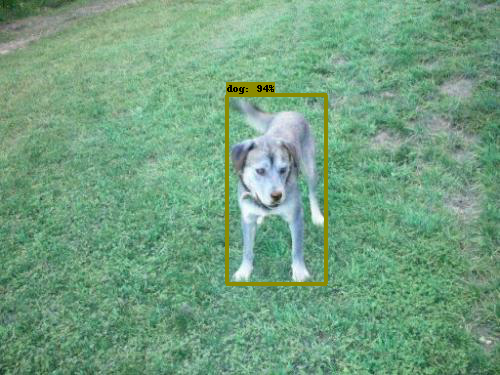

In [55]:
from google.colab.patches import cv2_imshow
cv2_imshow(image_np_with_detections) 

# New Section